In [2]:
!pip install transformers torch
!pip install conllu
!pip install minicons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 2.2 MB/s eta 0:00:00


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import conllu
import random
import pandas as pd

import numpy as np
from tqdm.notebook import tqdm
from minicons import scorer
from collections import Counter
import math
import gzip
import os
import urllib.request

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Hungarian-Szeged/master/hu_szeged-ud-train.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Hungarian-Szeged/master/hu_szeged-ud-dev.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Hungarian-Szeged/master/hu_szeged-ud-test.conllu

--2026-01-20 07:20:53--  https://raw.githubusercontent.com/UniversalDependencies/UD_Hungarian-Szeged/master/hu_szeged-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1456431 (1.4M) [text/plain]
Saving to: ‘hu_szeged-ud-train.conllu’

hu_szeged-ud-train. 100%[===================>]   1.39M  --.-KB/s    in 0.06s   

2026-01-20 07:20:53 (21.6 MB/s) - ‘hu_szeged-ud-train.conllu’ saved [1456431/1456431]

--2026-01-20 07:20:53--  https://raw.githubusercontent.com/UniversalDependencies/UD_Hungarian-Szeged/master/hu_szeged-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... conn

In [8]:
random.seed(42)

def get_negation_data_pools(filepaths):
    negation_pairs = []

    for path in filepaths:
        try:
            with open(path, "r", encoding="utf-8") as f:
                data = conllu.parse(f.read())

            for sentence in data:
                id_to_token = {t['id']: t for t in sentence}

                for token in sentence:
                    if token['deprel'] == 'compound:preverb':
                        head_id = token['head']
                        if head_id in id_to_token:
                            head = id_to_token[head_id]

                            if head['upos'] == 'VERB':
                                mood = head.get('feats', {}).get('Mood', 'Ind')

                                feats = head.get('feats', {})
                                person = feats.get('Person', '')
                                number = feats.get('Number', '')
                                tense = feats.get('Tense', '')
                                definite = feats.get('Definite', '')

                                negation_pairs.append({
                                    'preverb': token['form'].lower(),
                                    'verb': head['form'].lower(),
                                    'mood': mood,
                                    'person': person,
                                    'number': number,
                                    'tense': tense,
                                    'definite': definite
                                })
        except FileNotFoundError:
            print(f"Warning: File {path} not found.")

    unique_pairs = list({(p['preverb'], p['verb'], p['mood']): p for p in negation_pairs}.values())
    print(f"unique pairs found in data: {len(unique_pairs)}")
    return unique_pairs

def generate_negation_evaluation_suite(pairs, target_count=500):
    random.shuffle(pairs)
    selected_pairs = pairs[:target_count]

    dataset = []
    for pair in selected_pairs:
        if pair['mood'] == 'Imp':
            op = "Ne"
            op_type = "Prohibitive"
        else:
            op = "Nem"
            op_type = "Declarative"

        gram = f"{op} {pair['verb']} {pair['preverb']}"
        ungram = f"{op} {pair['preverb']}{pair['verb']}"

        dataset.append({
            'phenomenon': 'Negation',
            'preverb': pair['preverb'],
            'verb': pair['verb'],
            'grammatical': gram,
            'ungrammatical': ungram,
            'operator_type': op_type,
            'mood_detected': pair['mood'],
            'person': pair['person'],
            'number': pair['number'],
            'tense': pair['tense'],
            'definite': pair['definite']
        })

    df = pd.DataFrame(dataset)

    print("preerb frquency")
    freq_table = df['preverb'].value_counts().reset_index()
    freq_table.columns = ['Preverb', 'Count']
    print(freq_table.to_string(index=False))

    return df

In [9]:
files = [
    "hu_szeged-ud-train.conllu",
    "hu_szeged-ud-dev.conllu",
    "hu_szeged-ud-test.conllu"
]

pairs_pool = get_negation_data_pools(files)
df_final = generate_negation_evaluation_suite(pairs_pool, target_count=500)

df_final.to_csv("hungarian_negation_minimal_pairs.csv", index=False, encoding='utf-8-sig')

unique pairs found in data: 413
preerb frquency
Preverb  Count
    meg     92
     el     66
     ki     64
    fel     47
     be     34
     át     18
     le     12
    elő     11
 vissza      8
  össze      7
  hozzá      6
     rá      4
   bele      4
    föl      4
    alá      4
   szét      4
   haza      3
  végre      3
  észre      2
  közzé      2
 szembe      2
   utol      2
  létre      2
  végig      1
  közre      1
  előre      1
  egyet      1
    oda      1
 együtt      1
  felül      1
  végbe      1
  hátra      1
 tovább      1
   újra      1
   jóvá      1


In [12]:
def build_webcorpus_unigrams(tokenizer, max_tokens=20_000_000):
    base_url = "https://nessie.ilab.sztaki.hu/~ndavid/Webcorpus2_text/"
    token_counts = Counter()
    total_tokens = 0

    for i in tqdm(range(1, 101), desc="Webcorpus 2.0 files"):
        filename = f"2017_2018_{i:04d}.txt.gz"
        local_file = f"webcorpus_{i:04d}.txt.gz"

        if total_tokens > max_tokens:
            break

        if not os.path.exists(local_file):
          url = f"{base_url}{filename}"
          urllib.request.urlretrieve(url, local_file)


        with gzip.open(local_file, 'rt', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    tokens = tokenizer(line)['input_ids']
                    token_counts.update(tokens)
                    total_tokens += len(tokens)

    unigram_logprobs = {tid: math.log(count / total_tokens)
                       for tid, count in token_counts.items()}

    torch.save(unigram_logprobs, "model_hun_webcorpus2_unigrams.pt")
    return unigram_logprobs

#replace with babylm for multilingual model
model_id = "goldfish-models/hun_latn_1000mb" #"BabyLM-community/ALL-baseline-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)
unigram_path = "model_hun_webcorpus2_unigrams.pt"

try:
    unigram_logprobs = torch.load(unigram_path, map_location="cpu")
    print(f"Loaded {len(unigram_logprobs)} webcorpus 2.0 unigrams")
except FileNotFoundError:
    unigram_logprobs = build_webcorpus_unigrams(tokenizer)

model_raw = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
ilm_model = scorer.IncrementalLMScorer(model_raw, "cuda" if torch.cuda.is_available() else "cpu", tokenizer=tokenizer)

def score_pair(ilm_model, sen, wrong_sen):
    return ilm_model.sequence_score([sen, wrong_sen], reduction=lambda x: x)

def run_eval(model, df, tokenizer, unigrams, column_grammatical, column_ungrammatical):
    results = df.copy()
    oov_backoff = -5  # for tokens not in your unigram sample, not even used based on statistics
    total_oov_count = 0
    total_tokens_processed = 0

    for idx, row in tqdm(results.iterrows(), total=len(results)):
        sen_prob, wrong_prob = score_pair(model, row[column_grammatical], row[column_ungrammatical])
        sen_tokens = tokenizer(row[column_grammatical])['input_ids']
        wrong_tokens = tokenizer(row[column_ungrammatical])['input_ids']
        sen_lp_sum = sen_prob.sum().item()
        wrong_lp_sum = wrong_prob.sum().item()
        sen_len = len(sen_prob)
        wrong_len = len(wrong_prob)


        sen_uni_vals = [unigrams.get(tid, oov_backoff) for tid in sen_tokens[1:]]
        wrong_uni_vals = [unigrams.get(tid, oov_backoff) for tid in wrong_tokens[1:]]
        sen_oovs = sen_uni_vals.count(oov_backoff)
        wrong_oovs = wrong_uni_vals.count(oov_backoff)

        total_oov_count += (sen_oovs + wrong_oovs)
        total_tokens_processed += (len(sen_uni_vals) + len(wrong_uni_vals))
        sen_uni_sum = sum(unigrams.get(tid, oov_backoff) for tid in sen_tokens[1:])
        wrong_uni_sum = sum(unigrams.get(tid, oov_backoff) for tid in wrong_tokens[1:])

        #metrics
        sen_lp_norm = sen_lp_sum / sen_len
        wrong_lp_norm = wrong_lp_sum / wrong_len

        sen_slor = (sen_lp_sum - sen_uni_sum) / sen_len
        wrong_slor = (wrong_lp_sum - wrong_uni_sum) / wrong_len

        results.at[idx, 'sen_lp_norm'] = sen_lp_norm
        results.at[idx, 'wrong_lp_norm'] = wrong_lp_norm
        results.at[idx, 'sen_slor'] = sen_slor
        results.at[idx, 'wrong_slor'] = wrong_slor
        results.at[idx, 'sen_nll'] = -sen_lp_sum
        results.at[idx, 'wrong_nll'] = -wrong_lp_sum

    results['nll_correct'] = (results['wrong_nll'] - results['sen_nll']) > 0
    results['norm_correct'] = (results['sen_lp_norm'] - results['wrong_lp_norm']) > 0
    results['slor_correct'] = (results['sen_slor'] - results['wrong_slor']) > 0

    oov_rate = (total_oov_count / total_tokens_processed) * 100
    print(f"Total Tokens Checked: {total_tokens_processed}")
    print(f"Total OOV Backoffs:   {total_oov_count}")
    print(f"OOV Rate:             {oov_rate:.4f}%")

    return results


Loaded 48176 webcorpus 2.0 unigrams


In [13]:
experiments = [
    {
        "version": "Bare",
        "file": "./hungarian_negation_preverb_minimal_pair.csv",
        "col_good": "grammatical",
        "col_bad": "ungrammatical"
    },
    {
        "version": "Context",
        "file": "./hungarian_negation_preverb_minimal_pair.csv",
        "col_good": "grammatical_context",
        "col_bad": "ungrammatical_context"
    },
    {
        "version": "Intervener",
        "file": "./hungarian_negation_preverb_minimal_pair.csv",
        "col_good": "grammatical_context_adverb",
        "col_bad": "ungrammatical_context_adverb"
    },
    {
        "version": "Intervener2",
        "file": "./hungarian_negation_preverb_minimal_pair.csv",
        "col_good": "grammatical_context_adverb2",
        "col_bad": "ungrammatical_context_adverb2"
    }
]
all_detailed_results = []
for exp in experiments:
  v_name = exp['version']
  f_path = exp['file']
  col_g = exp['col_good']
  col_b = exp['col_bad']

  df_input = pd.read_csv(f_path, encoding='utf-8')
  column_grammatical = col_g
  column_ungrammatical = col_b

  print(f"Experiment {f_path}")
  res_df = run_eval(ilm_model, df_input, tokenizer, unigram_logprobs, column_grammatical, column_ungrammatical)
  res_df['version'] = v_name
  res_df['model_name'] = "Goldfish"

  cols_to_keep = ['verb',
                  'preverb',
                  'version',
                  'model_name',
                   col_g,
                   col_b,
                   'nll_correct',
                   'norm_correct',
                   'slor_correct',
                   'sen_nll',
                   'sen_lp_norm',
                   'sen_slor',
                   'wrong_nll',
                   'wrong_lp_norm',
                   'wrong_slor'
                   ]

  res_df_clean = res_df[cols_to_keep]
  all_detailed_results.append(res_df_clean)


master_df = pd.concat(all_detailed_results, ignore_index=True)

Experiment /content/hungarian_negation_minimal_pairs_CONTEXT_with_adverbs_EXPANDED.csv


  0%|          | 0/612 [00:00<?, ?it/s]

Total Tokens Checked: 5164
Total OOV Backoffs:   0
OOV Rate:             0.0000%
Experiment /content/hungarian_negation_minimal_pairs_CONTEXT_with_adverbs_EXPANDED.csv


  0%|          | 0/612 [00:00<?, ?it/s]

Total Tokens Checked: 8819
Total OOV Backoffs:   0
OOV Rate:             0.0000%
Experiment /content/hungarian_negation_minimal_pairs_CONTEXT_with_adverbs_EXPANDED.csv


  0%|          | 0/612 [00:00<?, ?it/s]

Total Tokens Checked: 10089
Total OOV Backoffs:   0
OOV Rate:             0.0000%
Experiment /content/hungarian_negation_minimal_pairs_CONTEXT_with_adverbs_EXPANDED.csv


  0%|          | 0/612 [00:00<?, ?it/s]

Total Tokens Checked: 11317
Total OOV Backoffs:   0
OOV Rate:             0.0000%


In [14]:
def create_metric_summary_table(master_df):
    summary = master_df.groupby(['model_name', 'version'])[[
        'nll_correct',
        'norm_correct',
        'slor_correct'
    ]].mean() * 100


    summary = summary.rename(columns={
        'nll_correct': 'NLL Accuracy (%)',
        'norm_correct': 'Length-Norm Accuracy (%)',
        'slor_correct': 'SLOR Accuracy (%)',
    })

    summary = summary.round(2)
    summary = summary.reset_index()

    return summary

metric_table = create_metric_summary_table(master_df)
display(metric_table)

# print(metric_table.to_latex(index=False, float_format="%.2f"))

,model_name,version,NLL Accuracy (%),Length-Norm Accuracy (%),SLOR Accuracy (%)
0,Goldfish,Bare,93.30,82.84,79.74
1,Goldfish,Context,92.97,85.46,83.66
2,Goldfish,Intervener,79.41,79.25,73.69
3,Goldfish,Intervener2,47.39,60.78,52.45


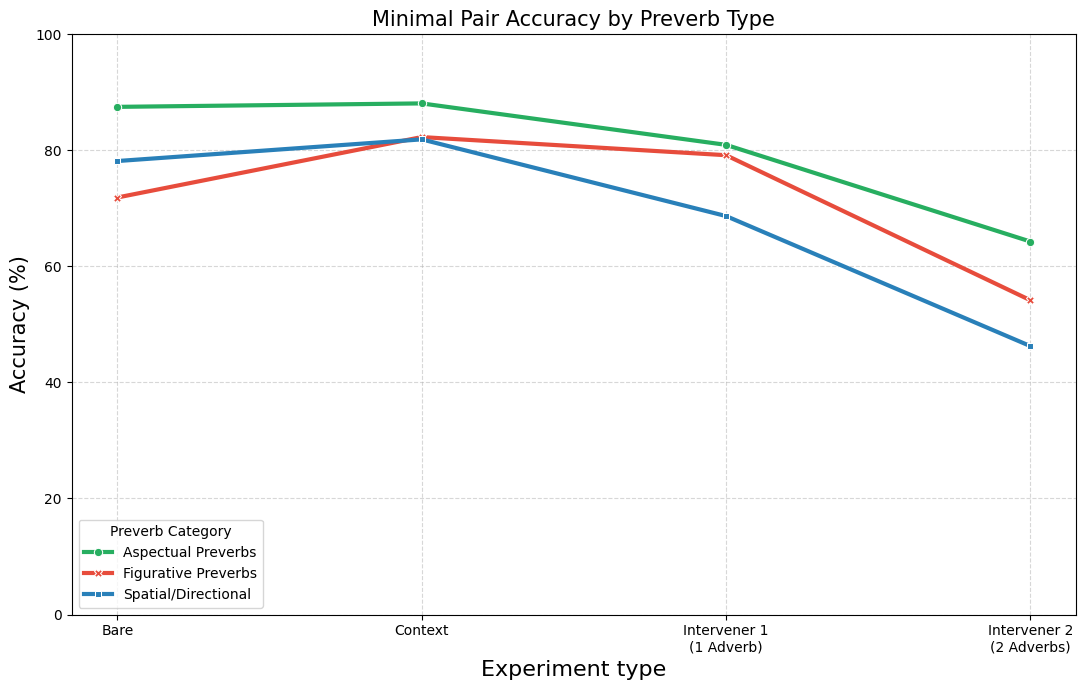

| Linguistic_Category   |   count |
|:----------------------|--------:|
| Spatial/Directional   |    1392 |
| Aspectual Preverbs    |     672 |
| Figurative Preverbs   |     384 |


In [16]:
def preverb_type(master_df, metric='slor_correct'):
    linguistic_map = {
        #Pure Aspectual
        'meg': 'Aspectual Preverbs',
        'el': 'Aspectual Preverbs',
        'újra': 'Aspectual Preverbs',

        #Spatial / Directional
        'ki': 'Spatial/Directional',
        'be': 'Spatial/Directional',
        'fel': 'Spatial/Directional',
        'föl': 'Spatial/Directional',
        'le': 'Spatial/Directional',
        'át': 'Spatial/Directional',
        'elő': 'Spatial/Directional',
        'előre': 'Spatial/Directional',
        'vissza': 'Spatial/Directional',
        'össze': 'Spatial/Directional',
        'hozzá': 'Spatial/Directional',
        'rá': 'Spatial/Directional',
        'bele': 'Spatial/Directional',
        'alá': 'Spatial/Directional',
        'szét': 'Spatial/Directional',
        'haza': 'Spatial/Directional',
        'szembe': 'Spatial/Directional',
        'végig': 'Spatial/Directional',
        'oda': 'Spatial/Directional',
        'felül': 'Spatial/Directional',
        'hátra': 'Spatial/Directional',
        'tovább': 'Spatial/Directional',

        # Idiomatic
        'végre': 'Figurative Preverbs',
        'észre': 'Figurative Preverbs',
        'közzé': 'Figurative Preverbs',
        'utol': 'Figurative Preverbs',
        'létre': 'Figurative Preverbs',
        'közre': 'Figurative Preverbs',
        'egyet': 'Figurative Preverbs',
        'együtt': 'Figurative Preverbs',
        'végbe': 'Figurative Preverbs',
        'jóvá': 'Figurative Preverbs'
    }

    plot_df = master_df.copy()
    plot_df['Linguistic_Category'] = plot_df['preverb'].map(linguistic_map)
    # plot_df = plot_df.dropna(subset=['Linguistic_Category'])
    summary = plot_df.groupby(['Linguistic_Category', 'version'])[metric].mean().reset_index()

    order = ['Bare', 'Context', 'Intervener', 'Intervener2']
    summary['version'] = pd.Categorical(summary['version'], categories=order, ordered=True)
    summary['Accuracy (%)'] = summary[metric] * 100





    #plot
    plt.figure(figsize=(11, 7))
    sns.lineplot(
        data=summary,
        x='version',
        y='Accuracy (%)',
        hue='Linguistic_Category',
        style='Linguistic_Category',
        markers=True,
        dashes=False,
        linewidth=3,
        palette={
            'Spatial/Directional': '#2980b9',
            'Aspectual Preverbs': '#27ae60',
            'Figurative Preverbs': '#e74c3c'
        }
    )

    plt.title(f"Minimal Pair Accuracy by Preverb Type", fontsize=15) #,fontweight='bold')
    plt.ylabel("Accuracy (%)", fontsize=15)
    plt.xlabel("Experiment type", fontsize=16
               )
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Preverb Category", loc='lower left')

    plt.xticks(
        ticks=[0, 1, 2, 3],
        labels=["Bare\n", "Context\n", "Intervener 1\n(1 Adverb)", "Intervener 2\n(2 Adverbs)"]
    )

    plt.tight_layout()
    plt.show()
    counts = plot_df['Linguistic_Category'].value_counts()
    print(counts.to_markdown())

preverb_type(master_df, metric='slor_correct')

In [ ]:
####CONFIDENCE####

In [17]:
# NLL: lower is better
master_df['nll_margin'] = master_df['wrong_nll'] - master_df['sen_nll']

# Length-Norm
master_df['norm_margin'] = master_df['sen_lp_norm'] - master_df['wrong_lp_norm']

# SLOR:
master_df['slor_margin'] = master_df['sen_slor'] - master_df['wrong_slor']

metrics = ['nll_margin', 'norm_margin', 'slor_margin']
print(master_df.groupby('version')[metrics].agg(['mean']))#, 'std', 'median']))

            nll_margin norm_margin slor_margin
                  mean        mean        mean
version                                       
Bare          4.028735    1.494739    1.187768
Context       4.111027    0.786007    0.599397
Intervener    2.795898    0.535657    0.366652
Intervener2  -0.024317    0.173260    0.023617


In [ ]:
######TOKENIZATION####

In [22]:
def tokenize_global(master_df, tokenizer, metric='slor_correct'):
    col_map = {
        "Bare": ("grammatical", "ungrammatical"),
        "Context": ("grammatical_context", "ungrammatical_context"),
        "Intervener": ("grammatical_context_adverb", "ungrammatical_context_adverb"),
        "Intervener2": ("grammatical_context_adverb2", "ungrammatical_context_adverb2")
    }

    def determine_category(row):
        v_type = row['version']
        if v_type not in col_map: return pd.Series([None]*2)

        pv_token = tokenizer.tokenize(f" {row['preverb']}")[-1]

        toks_good = tokenizer.tokenize(str(row[col_map[v_type][0]]))
        toks_bad = tokenizer.tokenize(str(row[col_map[v_type][1]]))

        good_is_split = any(t == pv_token for t in toks_good)
        bad_is_split = any(t == pv_token for t in toks_bad)

        if good_is_split and not bad_is_split:
            category = "WELL-SPLIT"
        else:
            category = "REST"

        return pd.Series({'category': category, 'is_correct': row[metric]})

    res = master_df.apply(determine_category, axis=1)
    df_merged = pd.concat([master_df, res], axis=1).dropna(subset=['category'])

    summary = df_merged.groupby('category')['is_correct'].agg(['mean', 'count']).reset_index()
    summary.columns = ['Category', 'Accuracy', 'Count']
    summary['Accuracy (%)'] = (summary['Accuracy'] * 100).round(2)

    return summary.sort_values('Accuracy', ascending=False), df_merged

summary_stats, detailed_df = tokenize_global(master_df, tokenizer)
print(summary_stats.to_markdown(index=False))

| Category   |   Accuracy |   Count |   Accuracy (%) |
|:-----------|-----------:|--------:|---------------:|
| WELL-SPLIT |   0.877193 |    1197 |          87.72 |
| REST       |   0.577138 |    1251 |          57.71 |


In [21]:
def tokenize_bare(master_df, tokenizer, metric='slor_correct'):

    df_bare = master_df[master_df['version'] == 'Bare'].copy()
    col_map = {
        "Bare": ("grammatical", "ungrammatical")
    }

    def determine_category(row):
        v_type = row['version']
        if v_type not in col_map:
            return pd.Series({'category': None, 'toks_good': None, 'toks_bad': None})


        pv_token = tokenizer.tokenize(f" {row['preverb']}")[-1]

        toks_good = tokenizer.tokenize(str(row[col_map[v_type][0]]))
        toks_bad = tokenizer.tokenize(str(row[col_map[v_type][1]]))

        good_is_split = any(t == pv_token for t in toks_good)
        bad_is_split = any(t == pv_token for t in toks_bad)

        if good_is_split and not bad_is_split:
            category = "WELL-SPLIT"
        else:
            category = "REST"

        return pd.Series({
            'category': category,
            'is_correct': row[metric],
            'toks_good': toks_good,
            'toks_bad': toks_bad
        })

    results = df_bare.apply(determine_category, axis=1)
    df_merged = pd.concat([master_df, results], axis=1).dropna(subset=['category'])

    summary = df_merged.groupby('category')['is_correct'].agg(['mean', 'count']).reset_index()
    summary.columns = ['Category', 'Accuracy', 'Count']
    summary['Accuracy%'] = (summary['Accuracy'] * 100).round(2)
    print("statistic (bare)")
    print(summary.to_markdown(index=False))

    print(f"\n ==== WELL-SPLIT")
    successes = df_merged[(df_merged['category'] == "WELL-SPLIT") & (df_merged['is_correct'] == True)].head(10)
    for _, r in successes.iterrows():
        print(f"\nPair: {r['preverb']} + {r['verb']} | CORRECT")
        print(f"  Ungramm: {r['toks_bad']}")
        print(f"  Gramm:   {r['toks_good']}")

    print(f"\n ==== WELL-SPLIT (INCORRECT)")
    failures = df_merged[(df_merged['category'] == "WELL-SPLIT") & (df_merged['is_correct'] == False)]
    if failures.empty:
        print("No Well-Split failures found.")
    else:
        for _, r in failures.iterrows():
            print(f"\nPair: {r['preverb']} + {r['verb']} | INCORRECT")
            print(f"  Ungramm: {r['toks_bad']}")
        print(f"  Gramm:   {r['toks_good']}")

    print(f"\n ==== REST")
    rest_examples = df_merged[df_merged['category'] == "REST"]
    for _, r in rest_examples.iterrows():
        status = "CORRECT" if r['is_correct'] else "INCORRECT"
        print(f"\nPair: {r['preverb']} + {r['verb']} | {status}")
        print(f"  Ungramm: {r['toks_bad']}")
        print(f"  Gramm:   {r['toks_good']}")

    return summary, df_merged

summary, detailed_df = tokenize_bare(master_df, tokenizer)

statistic (bare)
| Category   |   Accuracy |   Count |   Accuracy% |
|:-----------|-----------:|--------:|------------:|
| REST       |   0.625    |     312 |     62.5    |
| WELL-SPLIT |   0.976667 |     300 |     97.6667 |

 ==== WELL-SPLIT

Pair: fel + menteni | CORRECT
  Ungramm: ['▁Nem', '▁felment', 'ette']
  Gramm:   ['▁Nem', '▁mentette', '▁fel']

Pair: meg + valósít | CORRECT
  Ungramm: ['▁Nem', '▁megvalósít']
  Gramm:   ['▁Nem', '▁valósít', '▁meg']

Pair: ki + használja | CORRECT
  Ungramm: ['▁Ne', '▁kihasznál', 'ja']
  Gramm:   ['▁Ne', '▁használja', '▁ki']

Pair: meg + felelt | CORRECT
  Ungramm: ['▁Nem', '▁megfelel', 't']
  Gramm:   ['▁Nem', '▁felelt', '▁meg']

Pair: alá + támasztotta | CORRECT
  Ungramm: ['▁Nem', '▁alátámasztott', 'a']
  Gramm:   ['▁Nem', '▁támasztott', 'a', '▁alá']

Pair: el + szabadultak | CORRECT
  Ungramm: ['▁Nem', '▁elszabadul', 'tak']
  Gramm:   ['▁Nem', '▁szabadul', 'tak', '▁el']

Pair: meg + újítja | CORRECT
  Ungramm: ['▁Nem', '▁megújít', 'ja']
  Gr

In [ ]:
#####ATTNETION####

In [25]:
def helper(master_df, tokenizer, num_examples=5):
    samples = master_df[master_df['version'] == 'Bare'].head(num_examples)

    for idx, row in samples.iterrows():
        text = row['grammatical']
        preverb = row['preverb']
        verb = row['verb']

        tokens = tokenizer.tokenize(text)

        print(f"\n--- Example {idx}: {preverb} + {verb} ---")
        print(f"Full text: {text}")
        print(f"Tokens: {tokens}")

        for i, t in enumerate(tokens):
            if preverb.lower() in t.lower():
                print(f"  MATCH FOUND: '{t}' at index {i} matches Preverb '{preverb}'")
            if verb.lower() in t.lower():
                print(f"  MATCH FOUND: '{t}' at index {i} matches Verb '{verb}'")

# Run it
helper(master_df, tokenizer)


--- Example 0: fel + menteni ---
Full text: Nem mentette fel
Tokens: ['▁Nem', '▁mentette', '▁fel']
  MATCH FOUND: '▁fel' at index 2 matches Preverb 'fel'

--- Example 1: meg + valósít ---
Full text: Nem valósít meg
Tokens: ['▁Nem', '▁valósít', '▁meg']
  MATCH FOUND: '▁valósít' at index 1 matches Verb 'valósít'
  MATCH FOUND: '▁meg' at index 2 matches Preverb 'meg'

--- Example 2: ki + használja ---
Full text: Ne használja ki
Tokens: ['▁Ne', '▁használja', '▁ki']
  MATCH FOUND: '▁használja' at index 1 matches Verb 'használja'
  MATCH FOUND: '▁ki' at index 2 matches Preverb 'ki'

--- Example 3: meg + felelt ---
Full text: Nem felelt meg
Tokens: ['▁Nem', '▁felelt', '▁meg']
  MATCH FOUND: '▁felelt' at index 1 matches Verb 'felelt'
  MATCH FOUND: '▁meg' at index 2 matches Preverb 'meg'

--- Example 4: be + szervezte ---
Full text: Nem szervezte be
Tokens: ['▁Nem', '▁szervezte', '▁be']
  MATCH FOUND: '▁szervezte' at index 1 matches Verb 'szervezte'
  MATCH FOUND: '▁be' at index 2 matches Pre

In [26]:
def run_targeted_attention_analysis(master_df, model_obj, tokenizer, target_words=["Nem", "Ne", "nem", "ne"]):
    model = model_obj.model if hasattr(model_obj, 'model') else model_obj
    device = model.device
    all_data = []

    col_map = {
        "Bare": ("grammatical", "ungrammatical"),
        "Context": ("grammatical_context", "ungrammatical_context"),
        "Intervener": ("grammatical_context_adverb", "ungrammatical_context_adverb"),
        "Intervener2": ("grammatical_context_adverb2", "ungrammatical_context_adverb2")
    }

    def get_targeted_mass(text, preverb_str, verb_str):
        if not isinstance(text, str) or not text.strip(): return None

        inputs = tokenizer(text, return_tensors="pt").to(device)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
        if outputs.attentions is None: return None

        #source
        source_idx = -1
        for i, t in enumerate(tokens):
            clean_t = t.replace('▁', '').lower()
            if any(tgt.lower() == clean_t for tgt in target_words):
                source_idx = i
                break

        if source_idx == -1: return None

        #destination
        critical_indices = []
        for i, t in enumerate(tokens):
            clean_t = t.replace('▁', '').lower()
            if preverb_str.lower() in clean_t or verb_str.lower() in clean_t:
                critical_indices.append(i)

        if not critical_indices: return None

        layer_masses = []
        for layer_att in outputs.attentions:
            att_tensor = layer_att[0]
            att_matrix, _ = torch.max(att_tensor, dim=0) #maxpool

            mass = sum(att_matrix[dest_i, source_idx].item() for dest_i in critical_indices)
            layer_masses.append(mass)

        return layer_masses

    for _, row in tqdm(master_df.iterrows(), total=len(master_df), desc="Tracing Hungarian Circuits"):
        version = row['version']
        if version not in col_map: continue

        for is_gram, col_name in [(True, col_map[version][0]), (False, col_map[version][1])]:
            masses = get_targeted_mass(row[col_name], row['preverb'], row['verb'])
            if masses:
                for layer_i, m in enumerate(masses):
                    all_data.append({
                        "Layer": layer_i + 1,
                        "Attention_Mass": m,
                        "Is_Grammatical": is_gram,
                        "Version": version
                    })

    return pd.DataFrame(all_data)

print(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True)
df_attention_results = run_targeted_attention_analysis(master_df, model, tokenizer)


goldfish-models/hun_latn_1000mb


Tracing Hungarian Circuits:   0%|          | 0/2448 [00:00<?, ?it/s]

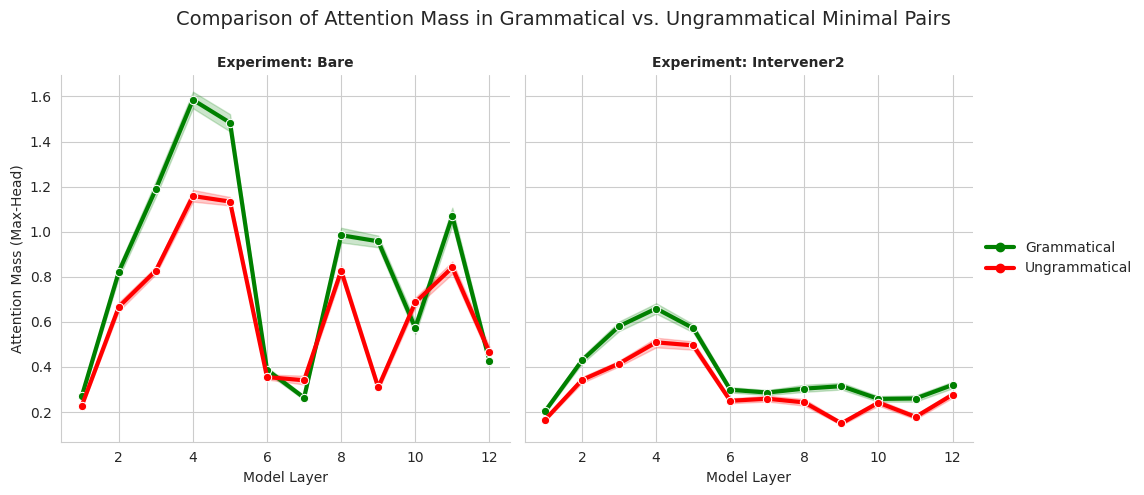

In [28]:
def visualize_att(df_results):
    df_plot = df_results.copy()
    df_plot[' '] = df_plot['Is_Grammatical'].map({
        True: 'Grammatical',
        False: 'Ungrammatical'
    })

    df_plot = df_plot[df_plot['Version'].isin(['Bare', 'Intervener2'])]

    sns.set_style("whitegrid")
    palette_colors = {'Grammatical': 'green', 'Ungrammatical': 'red'}

    g = sns.relplot(
        data=df_plot,
        x="Layer", y="Attention_Mass",
        hue=" ",
        col="Version",
        kind="line",
        palette=palette_colors,
        marker="o", linewidth=3,
        errorbar=('ci', 95),
        facet_kws={'sharey': True}
    )

    g.set_axis_labels("Model Layer", "Attention Mass (Max-Head)")
    g.set_titles("Experiment: {col_name}", fontweight='bold')

    plt.subplots_adjust(top=0.85)
    g.figure.suptitle("Comparison of Attention Mass in Grammatical vs. Ungrammatical Minimal Pairs", fontsize=14)

    plt.show()

visualize_att(df_attention_results)